In [1]:
import numpy as np
import pandas as pd
import random
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
class city():
    def __init__(self,name,x,y):
        self.name=name
        self.x=x
        self.y=y
    def __repr__(self):
        print(self.name,self.x,self.x)
        return ''

In [3]:
class chromosome:
    def __init__(self, lst):
        self.path = lst
        self.fitness = -1
        self.cost = -1
    
        
    def __repr__(self):
        print(self.path,self.cost)
        return ''

In [4]:
def calc_dist(p1,p2):
    return np.sqrt((p1.x-p2.x)**2+(p1.y-p2.y)**2)

In [5]:
def calc_cost(crom, mat):
    total_cost = 0
    lst = crom.path
    n=len(lst)
    # sum up the distances between each two adjacent genes
    for i in range(1,n):
        total_cost += mat[lst[i].name][lst[i-1].name]
    
    total_cost += mat[lst[0].name][lst[-1].name]
    return total_cost

In [6]:
def generate(lst_cities, n, dist_mat):
    generation = []
    # create random croms
    for i in range(n):
        crom = lst_cities.copy()
        random.shuffle(crom)
        
        c = chromosome(crom)
        # calculate the cost for the created crom path
        cost = calc_cost(c, dist_mat)
        
        c.cost=cost
        c.fitness=1/cost
        # add the crom to the pop
        generation.append(c)
        
    return generation

In [7]:
def gen_dist_matrix(data):
    n = len(data)
    mat = {}   
    for point in data: 
        key = point.name
        mat[key] = {}
        # for each data point calc the distance between it and all the other points
        for j in range(n):
            p2 = data[j]
            c = p2.name
            mat[key][c] = calc_dist(point,p2)
                
    return mat

# ACO

### **according to the update pheromon matrix equation**
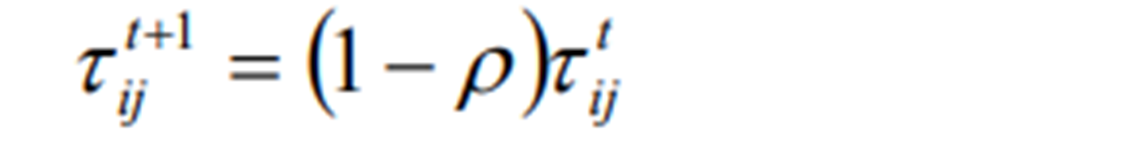




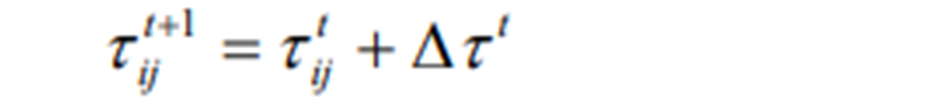

In [8]:
def update_phromone_matrix(phormone_mat, pop, roo = 0.5):

   
    for key, dic in phormone_mat.items():
        nw = {key: val*(1-roo) for key, val in dic.items()}
        phormone_mat[key] = nw
        
    new_phormone_mat=phormone_mat
    # sum each partial path to the population matrix
    for ant in pop:  
        lst = ant.path
        path_fit = ant.fitness
        
        n=len(lst)
        for i in range(1,n):
            # add the ants saved pheromones in the previous step to phormone matrix
            phormone_mat[lst[i].name][lst[i-1].name] += path_fit
            phormone_mat[lst[i-1].name][lst[i].name] += path_fit
   
        phormone_mat[lst[0].name][lst[-1].name] += path_fit 
        phormone_mat[lst[-1].name][lst[0].name] += path_fit
        
    return phormone_mat

In [9]:
def initial_phromone_matrix(data, initial_pop):  
    n = len(data)
    phormone_mat = {} 
    
    for point in data:
        key = point.name
        phormone_mat[key] = {}
    for point in data: 
        key = point.name
         # for each data point calc the distance between it and all the other points
        for j in range(n):
            p2 = data[j]
            c = p2.name
            phormone_mat[key][c] = 0.0001
    # for intially it = the update 
    phormone_mat = update_phromone_matrix(phormone_mat, initial_pop, roo = 0.9999)
    return phormone_mat

### **According to the selection probabilities equation in the construction phase**
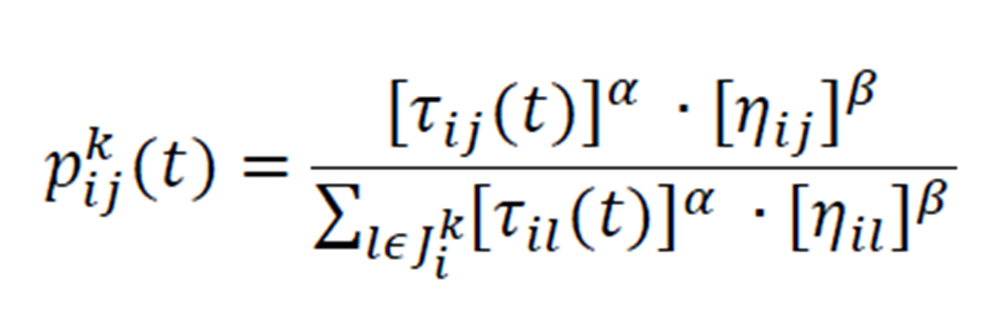

In [10]:
def pick_move(data,city,phormone_mat, dist_mat, vis,alpha=1,beta=3):
    prop_city_all = {}
    prop_sum = 0
    # calculate next step
    for c in data:
        if c.name not in vis:
            prop = (phormone_mat[city.name][c.name] ** alpha) * ((1.0/dist_mat[city.name][c.name])** beta)
            prop_city_all[c.name] = prop
            prop_sum += prop

    # after getting the whole probabilites divid them by their sum
    for c in prop_city_all:
        prop_city_all[c] /= prop_sum

    # select max probability
    selected = max(prop_city_all, key = prop_city_all.get) 

    # find which city with the max probability
    selected_city = None
    for c in data:
        if c.name == selected:
            selected_city = c
            
    return selected_city
                    

In [11]:
def construct_solution(data, dist_mat, phormone_mat, alpha,beta,size):
    
    n = len(data)
    pop = []
    # construct a solution of size the intial pop that contains 50 croms 
    for i in range(size): 
        vis = {}
        #chose a random start C0
        C0 = random.randrange(n-1)
        city = data[C0] 
        path = [city]
        vis[city.name] = 1
        
        # loop until construct one path of length n
        while len(vis) < n:
            # choose the next city in crom according to the probablity equation
            nxt=pick_move(data,city,phormone_mat, dist_mat, vis,alpha,beta)
            
            # append city into path and mark it in the visited list
            path.append(nxt)
            vis[nxt.name] = 1
            # update the current city
            city= nxt
            
        
        # append path
        s = chromosome(path)
        cost = calc_cost(s, dist_mat)
        s.cost=cost
        s.fitness=1/cost
        pop.append(s)
        
    return pop     

In [12]:
def generations(data,gen_num,size,alpha,beta,ro):
    
     # 1- generate distance matrix
    dist_mat = gen_dist_matrix(data)
    
    # 2- generate intial population
    pop = generate(data, size, dist_mat) 
    
    # 3- generate intial population
    phormone_mat = initial_phromone_matrix(data, pop)
    
    for i in range(gen_num):
        # construct a new population of size the intial pop
        gen= construct_solution(data, dist_mat, phormone_mat, alpha,beta,size)
        # update the phromone matrix
        phormone_mat = update_phromone_matrix(phormone_mat, gen,ro)
     
        
    return gen


# Read data here

In [13]:
df=pd.read_csv('15-Points.csv')
df

,x,y,City
0,5.500000e-08,9.860000e-09,1
1,-2.887330e+01,-7.980000e-08,2
2,-7.929160e+01,-2.140330e+01,3
3,-1.465770e+01,-4.338960e+01,4
4,-6.474730e+01,2.189820e+01,5
5,-2.905850e+01,-4.321670e+01,6
6,-7.207850e+01,1.815810e-01,7
7,-3.603660e+01,-2.161350e+01,8
8,-5.048080e+01,7.374470e+00,9
9,-5.058590e+01,-2.158820e+01,10


In [14]:
data = [city(c,x,y) for c,x,y in zip(df['City'], df['x'], df['y'])]

In [15]:
gen_num=100
size=50
ln=15
alpha=1
beta=1
ro=0.3
generation=generations(data,gen_num,size,alpha,beta,ro)

In [16]:
best = max(generation, key = lambda x: x.fitness)

In [17]:
best.path.append(best.path[0])

In [18]:
for a in best.path:
    print(a.name,'-> ',end='')

5 -> 9 -> 15 -> 2 -> 13 -> 1 -> 11 -> 4 -> 6 -> 8 -> 10 -> 12 -> 14 -> 3 -> 7 -> 5 -> 

In [19]:
print('Cost is : ',best.cost)

Cost is :  292.5057967588864


In [20]:
def plot_cities(cities):
    # Extract x and y coordinates into separate lists
    x_coords = [city.x for city in cities.path]
    y_coords = [city.y for city in cities.path]

    # Create a Matplotlib figure
    fig, ax = plt.subplots()

    # Plot cities as scatter points
    ax.scatter(x_coords, y_coords)

    # Plot path between cities as lines
    for i in range(len(cities.path)-1):
        curr_city = cities.path[i]
        next_city = cities.path[i+1]
        ax.plot([curr_city.x, next_city.x], [curr_city.y, next_city.y],marker='>')

    # Show the plot
    plt.show()

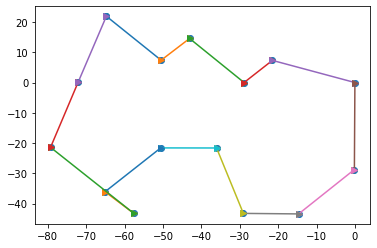

In [21]:
plot_cities(best)